In [2]:
import pretty_midi
import librosa
from matplotlib import pyplot as plt
import os
import miditok

In [3]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

/tmp/ipykernel_13963/4272272150.py:2: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


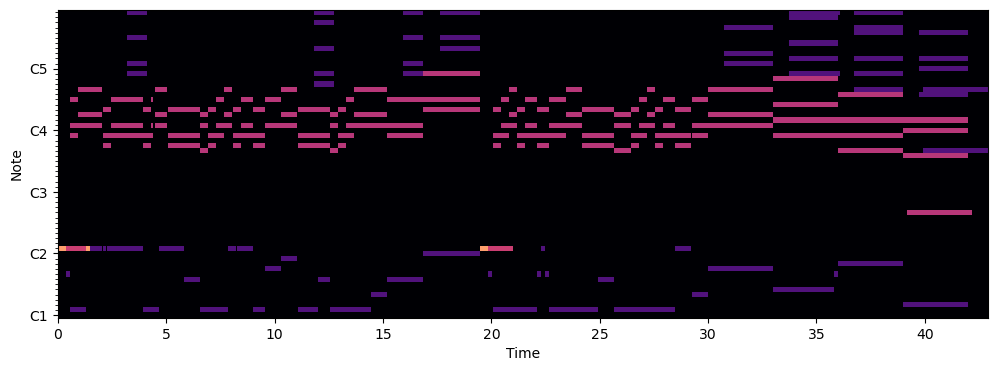

In [4]:
example_track_path = '../data/external/Jazz Midi/5To10.mid'
example_track = pretty_midi.PrettyMIDI(example_track_path)

plt.figure(figsize=(12, 4))
plot_piano_roll(example_track, 24, 84)

In [1]:
!wget -O ../models/model.pt http://vault.sfu.ca/index.php/s/Ff2j19IrKS5R969/download

--2024-11-11 17:03:10--  http://vault.sfu.ca/index.php/s/Ff2j19IrKS5R969/download
Resolving vault.sfu.ca (vault.sfu.ca)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘vault.sfu.ca’


In [5]:
db_path = '../data/external'
db_folders = [x[0] for x in os.walk(db_path)]
midi_file_paths = []
for folder_path in db_folders:
    midi_file_paths += [ os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.mid')]
print(f'Number of tracks: {len(midi_file_paths)}')

Number of tracks: 934


In [6]:
midis = []
for file_path in midi_file_paths:
    try:
        midis.append(pretty_midi.PrettyMIDI(file_path))
    except Exception as ex:
        # print(f'Exception occured: {type(ex).__name__}')
        continue

/home/julia/anaconda3/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [7]:
print(f'Number of properly loaded files: {len(midis)}')

Number of properly loaded files: 915


In [8]:
track_lengths = [ midi.get_end_time() for midi in midis ]
max_tl = max(track_lengths)
track_lengths_without_max = [tl for tl in track_lengths if tl < max_tl]
# plt.hist(track_lengths_without_max, bins=20, edgecolor='black')

In [9]:
sum(track_lengths)

211241.65849309575

(array([ 99.,  18.,  88.,  66., 224.,  71., 121.,  44.,  62.,  35.,  46.,
         11.,  11.,   4.,   7.,   1.,   3.,   2.,   1.,   1.]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ,
        17.5, 19. , 20.5, 22. , 23.5, 25. , 26.5, 28. , 29.5, 31. ]),
 <BarContainer object of 20 artists>)

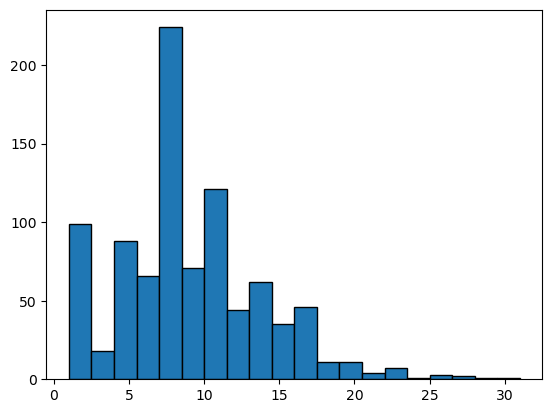

In [10]:
instrument_number = [ len(midi.instruments) for midi in midis ]
plt.hist(instrument_number, bins=20, edgecolor='black')

In [11]:
# divide into 4 bar chunks

# mmm tokenize it

In [63]:
import miditok
import torch

config = miditok.TokenizerConfig()
config.additional_params = { "base_tokenizer" : 'REMI' }

tokenizer = miditok.MMM(config)
example_track_path = '../data/external/Jazz Midi/5To10.mid'
encoded = tokenizer.encode(example_track_path)
encoded

TokSequence(tokens=['Track_Start', 'Program_35', 'Bar_None', 'Position_0', 'Pitch_37', 'Velocity_99', 'Duration_1.0.8', 'Position_8', 'Pitch_32', 'Velocity_99', 'Duration_0.4.8', 'Position_12', 'Pitch_25', 'Velocity_99', 'Duration_2.0.8', 'Position_28', 'Pitch_37', 'Velocity_99', 'Duration_2.0.8', 'Bar_None', 'Position_12', 'Pitch_37', 'Velocity_99', 'Duration_0.4.8', 'Position_16', 'Pitch_37', 'Velocity_99', 'Duration_1.4.8', 'Position_28', 'Pitch_37', 'Velocity_99', 'Duration_0.4.8', 'Bar_None', 'Position_0', 'Pitch_37', 'Velocity_99', 'Duration_2.4.8', 'Position_20', 'Pitch_25', 'Velocity_99', 'Duration_2.0.8', 'Bar_None', 'Position_4', 'Pitch_37', 'Velocity_99', 'Duration_2.0.8', 'Position_20', 'Pitch_37', 'Velocity_99', 'Duration_1.0.8', 'Position_28', 'Pitch_31', 'Velocity_99', 'Duration_2.0.8', 'Bar_None', 'Position_12', 'Pitch_25', 'Velocity_99', 'Duration_3.4.8', 'Bar_None', 'Position_8', 'Pitch_37', 'Velocity_99', 'Duration_1.0.8', 'Position_16', 'Pitch_37', 'Velocity_99', 'D

In [73]:
model_path = '../models/model.pt'
model = torch.jit.load(model_path)

model.train()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_ids = torch.tensor([encoded], dtype=torch.long).to(device)

In [ ]:
input_ids = input_ids[:, :1024]
print(input_ids.shape)

NameError: name 'input_ids' is not defined

In [75]:
batch_size = input_ids.size(0)
num_heads = 8           # Set based on model's actual configuration
hidden_dim = 512         # This is usually hidden_size / num_heads
sequence_length = input_ids.size(1)

argument_2 = tuple(
    (
        torch.zeros((batch_size, num_heads, sequence_length, hidden_dim // num_heads), dtype=torch.float32).to(device),  # past_key
        torch.zeros((batch_size, num_heads, sequence_length, hidden_dim // num_heads), dtype=torch.float32).to(device)   # past_value
    )
    for _ in range(6)  # Six layers, assuming GPT-2 small
)

In [76]:
# Forward pass with all required inputs
with torch.no_grad():
    output = model(input_ids, argument_2)

In [77]:
output.loss

AttributeError: 'tuple' object has no attribute 'loss'

In [47]:
logits = output[0][:, -1, :]
print(logits)

tensor([[ 0.2948,  1.8378,  4.2837,  3.7553,  2.1175,  5.4277,  3.2103,  4.2167,
          5.1601,  5.0275, -3.9065,  0.2614, -0.3526,  1.5869, -0.8594, -3.5976,
         -3.2293,  3.8535, -6.4041, -1.1233,  2.1145, -3.2043,  2.3005, -0.7897,
         -1.5143, -1.3743, -1.5151, -1.6075, -3.5416,  2.5976,  0.8081, -0.5545,
          0.4906, -1.3754,  0.5171,  0.5629,  1.5144, -2.8587,  1.9338,  0.9467,
          0.5666,  3.6651, -0.0393,  1.1159,  3.1059,  2.6309,  2.8465,  1.8318,
          2.2327,  3.9833,  3.5650,  3.1171,  3.7420,  1.0923,  2.4922,  3.5639,
          3.5688,  3.6057,  2.6297,  5.4248,  0.9916,  3.3337,  2.8091,  2.0454,
          0.0763,  1.1640,  0.3710,  0.8650,  1.2318,  0.6318,  6.2526,  0.9243,
          1.2764,  1.9615,  2.7025,  1.7472,  1.5801,  1.6693,  1.4655,  1.9350,
          2.7328,  1.7079,  3.4149,  2.8607,  0.3485,  1.7176,  2.3043,  2.6157,
          3.6229,  3.5691,  1.8051,  0.7003,  2.4726,  2.8257,  2.5660,  1.4532,
          2.0916,  2.7612,  

In [22]:
piece = output[0]
print(piece)

tensor([[[-1.9388, -2.9746, -2.2624,  ...,  1.1560, -1.3575, -1.0870],
         [-7.5199, -6.6788, -3.5914,  ...,  1.9656,  0.9051,  1.9962],
         [-4.4241, -2.1637, -3.1708,  ...,  6.8054,  7.2982,  6.7827],
         ...,
         [-1.6108,  1.0039,  2.1650,  ..., -1.0453, -1.7445,  0.5064],
         [-0.4664,  0.6102,  1.8975,  ...,  0.3313, -1.4791, -0.9564],
         [ 0.2948,  1.8378,  4.2837,  ..., -0.0639, -1.6674,  0.0242]]])


In [35]:
generated_tokens = output.squeeze().tolist()
generated_midi = tokenizer.decode(generated_tokens)

AttributeError: 'tuple' object has no attribute 'squeeze'

In [19]:
!pip3 install protobuf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 2.5 MB/s eta 0:00:00a 0:00:01


In [21]:
from google.protobuf.json_format import MessageToJson
output_str = MessageToJson(piece)

AttributeError: 'Tensor' object has no attribute 'DESCRIPTOR'

In [51]:
tokenizer.decode(piece)

ValueError: The input sequence does not have the expected dimension (3 instead of 1).

In [35]:
tokens = logits.argmax(dim=-1).squeeze().tolist()  # Convert logits to a list of token IDs

# Convert tokens to TokSequence
token_sequence = miditok.TokSequence(ids=tokens)

# Decode tokens to MIDI Score and save
midi_obj = tokenizer.decode([token_sequence])
midi_obj[0].dump("generated_output.mid")  # Save as MIDI file

KeyError: 570

In [25]:
!pip3 install miditoolkit

In [30]:
import torch
from miditok import MMM
from miditoolkit import MidiFile
from miditoolkit.midi.parser import MidiFile as mparser

# Load model and tokenizer
model_path = '../models/model.pt'  # replace with actual path to your model file
model = torch.load(model_path)
model.eval()  # Set model to evaluation mode

# Initialize the tokenizer
config = miditok.TokenizerConfig()
config.additional_params = { "base_tokenizer" : 'REMI' }

tokenizer = miditok.MMM(config)

def generate_multitrack_midi(input_midi_path, output_midi_path):
    # Step 1: Load and tokenize the input MIDI
    midi = MidiFile(input_midi_path)
    tokenized_input = tokenizer(input_midi_path)

    print(tokenized_input)

    # Prepare the input for the model
    input_tensor = torch.tensor([tokenized_input], dtype=torch.long)  # Adjust shape if needed

    # Step 2: Generate additional tracks with the model
    with torch.no_grad():
        output_tensor = model(input_tensor)  # Forward pass to get predictions

    # Convert model output tensor back to tokens
    generated_tokens = output_tensor.squeeze().tolist()

    # Step 3: Decode generated tokens back to MIDI format
    generated_midi = tokenizer.decode(generated_tokens)

    # Combine generated tracks with the original MIDI
    for track in generated_midi.instruments:
        midi.instruments.append(track)  # Append new instruments (tracks)

    # Step 4: Save the combined MIDI to a new file
    midi.dump(output_midi_path)

# Example usage
input_midi_path = '../data/external/Jazz Midi/5To10.mid'  # Path to input single-track MIDI
output_midi_path = 'multi_track_output.mid'  # Path to save generated multi-track MIDI

generate_multitrack_midi(input_midi_path, output_midi_path)


/home/julia/anaconda3/lib/python3.10/site-packages/torch/serialization.py:707: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


TokSequence(tokens=['Track_Start', 'Program_35', 'Bar_None', 'Position_0', 'Pitch_37', 'Velocity_99', 'Duration_1.0.8', 'Position_8', 'Pitch_32', 'Velocity_99', 'Duration_0.4.8', 'Position_12', 'Pitch_25', 'Velocity_99', 'Duration_2.0.8', 'Position_28', 'Pitch_37', 'Velocity_99', 'Duration_2.0.8', 'Bar_None', 'Position_12', 'Pitch_37', 'Velocity_99', 'Duration_0.4.8', 'Position_16', 'Pitch_37', 'Velocity_99', 'Duration_1.4.8', 'Position_28', 'Pitch_37', 'Velocity_99', 'Duration_0.4.8', 'Bar_None', 'Position_0', 'Pitch_37', 'Velocity_99', 'Duration_2.4.8', 'Position_20', 'Pitch_25', 'Velocity_99', 'Duration_2.0.8', 'Bar_None', 'Position_4', 'Pitch_37', 'Velocity_99', 'Duration_2.0.8', 'Position_20', 'Pitch_37', 'Velocity_99', 'Duration_1.0.8', 'Position_28', 'Pitch_31', 'Velocity_99', 'Duration_2.0.8', 'Bar_None', 'Position_12', 'Pitch_25', 'Velocity_99', 'Duration_3.4.8', 'Bar_None', 'Position_8', 'Pitch_37', 'Velocity_99', 'Duration_1.0.8', 'Position_16', 'Pitch_37', 'Velocity_99', 'D

RuntimeError: forward() is missing value for argument 'argument_2'. Declaration: forward(__torch__.transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel self, Tensor input_ids, ((Tensor, Tensor), (Tensor, Tensor), (Tensor, Tensor), (Tensor, Tensor), (Tensor, Tensor), (Tensor, Tensor)) argument_2) -> ((Tensor, ((Tensor, Tensor), (Tensor, Tensor), (Tensor, Tensor), (Tensor, Tensor), (Tensor, Tensor), (Tensor, Tensor))))